In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from data_analysis.helpers import *

164
163


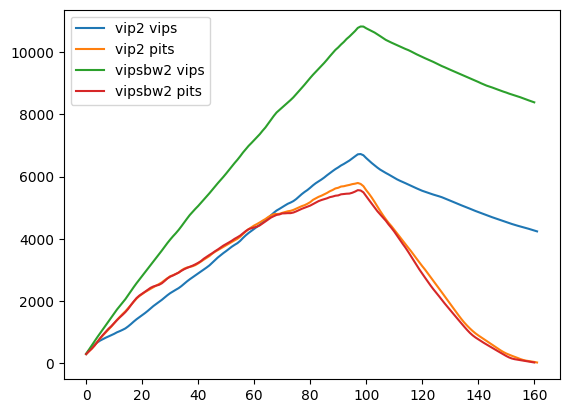

In [5]:
experiment_name = "some"
topology = "abilene"
config_path = "../sim_configs/" + experiment_name + "_config.json"
test_config = getTestConfig(config_path)
db_path = "../sim_outputs/" + experiment_name + "_" + topology + "_db.json"
db = getJsonDb(db_path)

request_rate = 15
request_dist_param = 0.5
case_filters = [
    ("request_rate", request_rate, None),
    ("request_dist_param", request_dist_param, None),
]

param_list = simConfigToParamSets(test_config)
param_list = filterParamList(param_list, case_filters)
fig, ax = plt.subplots()
for cache_pol in ["vipsbw","vipsbw2"]:
    filters = [("cache_pol", cache_pol, None)]
    pol_param_list = filterParamList(param_list, filters)
    assert len(pol_param_list) == 1
    param_hash = str(hash(pol_param_list[0]))
    vips = singleEntrySumDataFieldAcrossNodes(
        topology,
        db[param_hash],
        "vip_count_sum",
    )
    pits = singleEntrySumDataFieldAcrossNodes(
        topology,
        db[param_hash],
        "pit_count_sum",
    )
    delay = singleEntrySumDataFieldAcrossNodes(
        topology,
        db[param_hash],
        "delay",
    )
    hits = singleEntrySumDataFieldAcrossNodes(
        topology,
        db[param_hash],
        "cache_hits",
    )
    reps = singleEntrySumDataFieldAcrossNodes(
        topology,
        db[param_hash],
        "cache_replacements",
    )
    window_size = 3
    vip_moving_avg = np.convolve(vips, np.ones(window_size) / window_size, mode="valid")
    pit_moving_avg = np.convolve(pits, np.ones(window_size) / window_size, mode="valid")
    if cache_pol == "vip":
        drawstyle = "b"
    elif cache_pol == "vipsbw":
        drawstyle = "r"
    elif cache_pol == "vip2":
        drawstyle = "k"
    elif cache_pol == "vipsbw2":
        drawstyle = "y"
    ax.plot(range(len(vip_moving_avg)), vip_moving_avg, "-"+drawstyle)
    ax.plot(range(len(pit_moving_avg)), pit_moving_avg, "--"+drawstyle)
    print(cache_pol + " delay: " + str(delay))
    print(cache_pol + " hits: " + str(hits))
    print(cache_pol + " reps: " + str(reps))

ax.set_xlim([0, 95])
ax.set_xlabel("Time slot")
ax.set_ylabel("Sum of queue backlogs")
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0), useMathText=True)
#ax.legend(["VIP queues", "PIT queues", "VIP queues w/ cache bw constraint", "PIT queues w/ cache bw constraint"])
ax.legend(["VIP queues", "PIT queues", "VIP queues w/ averaging", "PIT queues w/ averaging"])
fig_name = "_".join(tuple(map(str,(experiment_name,topology,request_rate,request_dist_param))))
fig_path = "../sim_outputs/" + fig_name + ".pdf"
#plt.savefig(fig_path)
plt.show()